In [67]:
import os, shutil
import pandas as pd
from Bio import SeqIO
import numpy as np
from Bio import AlignIO
from collections import Counter
from Bio import Seq

### Extract fasta sequences for the autotrophic rubiscos

In [62]:
uclust_data = pd.read_csv('../output/01_uclust_all_0.7.csv')
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data['cut Target'] = uclust_data.Target.apply(lambda x: x.split(' ')[0])
auto_id = [x.replace('\n','') for x in open('../output/20190410_run/20190410_autotrophic_rubisco_70p.txt').readlines() if x != '\n']
autotrophic_rubisco  = uclust_data.loc[uclust_data['cut Target'].isin(auto_id),'Query'].values

In [77]:
auto_seq = []
for record in SeqIO.parse('../data/merged_data_clean.faa', "fasta"):
    if record.description in autotrophic_rubisco:
        auto_seq.append(record)

with open(r"../data/autotrophic_rubisco_seq.faa", "w") as output_handle:
    SeqIO.write(auto_seq, output_handle, "fasta")

In [78]:
!../bin/usearch11.0.667_i86linux32 -cluster_fast ../data/autotrophic_rubisco_seq.faa -id 0.9 -uc ../output/auto_uclust_all_0.9.uc

usearch v11.0.667_i86linux32, 4.0Gb RAM (16.3Gb total), 8 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: yinonmoise.baron@weizmann.ac.il

00:01 71Mb    100.0% Reading ../data/autotrophic_rubisco_seq.faa
00:01 109Mb   100.0% DF
00:01 111Mb  46200 seqs, 45451 uniques, 45025 singletons (99.1%)
00:01 111Mb  Min size 1, median 1, max 48, avg 1.02
00:01 117Mb   100.0% DB
00:02 175Mb   100.0% 776 clusters, max size 8488, avg 59.5
                                                          
      Seqs  45451 (45.5k)
  Clusters  776
  Max size  8488
  Avg size  59.5
  Min size  1
Singletons  245, 0.5% of seqs, 31.6% of clusters
   Max mem  175Mb
      Time  1.00s
Throughput  45.5k seqs/sec.



In [79]:
header = ['Type','Cluster','Size','%Id','Strand','Qlo','Tlo','Alignment','Query','Target']
uclust = pd.read_csv(r"../output/auto_uclust_all_0.9.uc", sep='\t', names=header, index_col=False)
centroids = uclust[uclust['Type']=='C']
c_list = centroids.iloc[:,8].values
c_list = [c.split(" ")[0] for c in c_list]

sequences = []
for record in SeqIO.parse('../data/autotrophic_rubisco_seq.faa', "fasta"):
    if record.id in c_list:
        sequences.append(record)

seq2 = []
seq3 = []
for i,record in enumerate(sequences):
    if not record.id in seq2: 
        seq2.append(record.id)
        seq3.append(record)

        
with open(r"../output/auto_uclust_all_0.9.faa", "w") as output_handle:
    SeqIO.write(seq3, output_handle, "fasta")

uclust.to_csv(r'../output/auto_uclust_all_0.9.csv',index=False)

In [80]:
!../bin/mafft-linux64/mafft.bat ../output/auto_uclust_all_0.9.faa > ../output/auto_uclust_all_0.9.aln

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  701 / 776
done.

Constructing a UPGMA tree (efffree=0) ... 
  770 / 776
done.

Progressive alignment 1/2... 
STEP   501 / 775 
Reallocating..done. *alloclen = 2430
STEP   701 / 775 
Reallocating..done. *alloclen = 4043

done.

Making a distance matrix from msa.. 
  700 / 776
done.

Constructing a UPGMA tree (efffree=1) ... 
  770 / 776
done.

Progressive alignment 2/2... 
STEP   701 / 775 
Reallocating..done. *alloclen = 2562

Reallocating..done. *alloclen = 3819

done.

disttbfast (aa) Version 7.427
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring sche

In [81]:
aln = AlignIO.read('../output/auto_uclust_all_0.9.aln',format='fasta')
mask = []
for i in range(0,aln.get_alignment_length()):
    mask.append(Counter(aln[:,i])['-']/len(aln[:,i])<0.95)
    
np_aln = np.array(aln)
np_aln = np_aln[:,mask]

aln_faa = SeqIO.parse('../output/auto_uclust_all_0.9.aln',format='fasta')
sequences = []
for record,i in zip(aln_faa,range(0,len(aln))):
    record.seq = Seq.Seq("".join(np_aln[i,:]), Seq.Alphabet.SingleLetterAlphabet())
    sequences.append(record)
        
with open(r"../output/auto_uclust_all_0.9_trimmed.aln", "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")


In [82]:
!curl -u yinonbaron:Mchcav11~ -H cipres-appkey:rubisco_phylogeny-49F87B124F3D429FBE12F95E4254DDEA https://cipresrest.sdsc.edu/cipresrest/v1/job/yinonbaron -F tool=RAXMLHPC8_REST_XSEDE  -F input.infile_=@../output/auto_uclust_all_0.9_trimmed.aln -F metadata.statusEmail=true -F vparam.datatype_=protein -F vparam.runtime_=160 -F  vparam.select_analysis_=fa -F vparam.choose_bootstrap_=x -F vparam.printbrlength_=1

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<jobstatus>
    <selfUri>
        <url>https://cipresrest.sdsc.edu/cipresrest/v1/job/yinonbaron/NGBW-JOB-RAXMLHPC8_REST_XSEDE-FCB5613CCDD144BEB2464F9FB2A04F31</url>
        <rel>jobstatus</rel>
        <title>NGBW-JOB-RAXMLHPC8_REST_XSEDE-FCB5613CCDD144BEB2464F9FB2A04F31</title>
    </selfUri>
    <jobHandle>NGBW-JOB-RAXMLHPC8_REST_XSEDE-FCB5613CCDD144BEB2464F9FB2A04F31</jobHandle>
    <jobStage>QUEUE</jobStage>
    <terminalStage>false</terminalStage>
    <failed>false</failed>
    <metadata>
        <entry>
            <key>statusEmail</key>
            <value>true</value>
        </entry>
    </metadata>
    <dateSubmitted>2019-04-10T07:20:09-07:00</dateSubmitted>
    <resultsUri>
        <url>https://cipresrest.sdsc.edu/cipresrest/v1/job/yinonbaron/NGBW-JOB-RAXMLHPC8_REST_XSEDE-FCB5613CCDD144BEB2464F9FB2A04F31/output</url>
        <rel>results</rel>
        <title>Job Results</title>
    </resultsUri>
    <workingDirUri>
     

In [88]:
labels = pd.read_csv('../data/jaffe_et_al_2018_rubisco_types.csv')
uclust_data = pd.read_csv('../output/auto_uclust_all_0.9.csv')
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data = uclust_data.merge(labels, left_on='Query', right_on='ID',how='left')
labeled_leaves = uclust_data[~pd.isna(uclust_data['type'])]
#labels[~labels['ID'].isin(uclust_data['ID'])]
#labels
#color_map = {'1': '#a0bc5d', '2': '#1d69d2', '3':'#ff0000','2_3':'#ffbf00'}
color_map = {'I': '#28B463', 'II': '#E74C3C', 'II/III':'#AF7AC5','IIIa':'#AED6F1','IIIb':'#3498DB','IIIc':'#1F618D','IIIlike':'#5D6D7E','IV':'#F4D03F','IVlike':'#F8C471','unknown':'#17202A'}
lines = labeled_leaves['Target'].apply(lambda x: x.split(' ')[0]).values +[',label,node,'+color_map[x]+',1,normal\n' for x in labeled_leaves['type'].values]
lines = set(lines)

In [84]:
with open('../data/itol_legend_template.txt','r') as file:
    with open("../output/auto_type_legend.txt", "w") as f1:
        for row in file:
            f1.write(row)
        for line in lines:
            f1.write(line)
        file.close()
        f1.close()

In [89]:
flamholz_data = pd.DataFrame([x.description for x in SeqIO.parse('../data/flamholz_et_al_2019_kinetically_characterized.faa', "fasta")],columns=['kinetic_ID'])
uclust_data = uclust_data.merge(flamholz_data, left_on='Query', right_on='kinetic_ID',how='left')
kinetic_measured = uclust_data[~pd.isna(uclust_data['kinetic_ID'])]
lines = kinetic_measured['Target'].apply(lambda x: x.split(' ')[0]).values + ',1,-1\n'

synth_data = pd.DataFrame([x.description for x in SeqIO.parse('../data/milo_synthetized_rubisco.faa', "fasta")],columns=['syn_ID'])
uclust_data = uclust_data.merge(synth_data, left_on='Query', right_on='syn_ID',how='left')
synth = uclust_data[~pd.isna(uclust_data['syn_ID'])]
lines_synth = synth['Target'].apply(lambda x: x.split(' ')[0]).values + ',-1,1\n'

with open('../data/kinetic_sampling_legend.txt','r') as file:
    with open("../output/auto_kinetic_legend.txt", "w") as f1:
        for row in file:
            f1.write(row)
        for line in lines:
            f1.write(line)
        for line in lines_synth:
            f1.write(line)
        file.close()
        f1.close()

In [141]:

tree = Phylo.read('../output/jaffe_RAxML_BestTree.result', 'newick')
#[tree.get_path(x)[-2] for x in tree.find_clades(terminal=True) if x.branch_length>0.15]
tree.get_terminals()[0]

Clade(branch_length=0.039893571402007014, name='Thioalkalimicrobium_cyclicum_YP_00453780_REF')

In [90]:
import itertools
from Bio import Phylo
t = Phylo.read('../output/20190410_auto/20190410_auto_RAxML_bestTree.result', 'newick')

d = {}
for x, y in itertools.combinations(t.get_terminals(), 2):
    v = t.distance(x, y)
    d[x.name] = d.get(x.name, {})
    d[x.name][y.name] = v
    d[y.name] = d.get(y.name, {})
    d[y.name][x.name] = v
for x in t.get_terminals():
    d[x.name][x.name] = 0

m = pd.DataFrame(d)


In [110]:
m2 = m[m < 0.4]
m2.loc['07M_4_2014_scaffold_14364_2',~pd.isna(m2.loc['07M_4_2014_scaffold_14364_2'])]

gwf2_scaffold_583_77           0.353457
07M_4_2014_scaffold_14364_2    0.000000
Name: 07M_4_2014_scaffold_14364_2, dtype: float64

In [118]:
m2 = m.reset_index().melt(id_vars=['index'],var_name='date',value_name='dist')

In [132]:
m2

,index,date,dist
0,07M_4_2014_scaffold_14364_2,RBC4_62,3.465773
1,07M_4_2014_scaffold_3235_2,RBC4_62,3.170785
2,16ft_4_scaffold_46755_1,RBC4_62,4.729039
3,AR10.1_scaffold_1790_3,RBC4_62,4.228054
4,Alkalilimnicola_ehrlichii_YP_74366_REF,RBC4_62,5.135091
5,CG02_land_8_20_14_3.00_150_scaffold_3515_6,RBC4_62,3.365189
6,CG03_land_8_20_14_0.80_scaffold_45401_2,RBC4_62,4.734953
7,CG08_land_8_20_14_0.20_scaffold_141789_1,RBC4_62,4.276209
8,CG08_land_8_20_14_0.20_scaffold_311_25,RBC4_62,4.407538
9,CG10_big_fil_rev_8_21_14_0.10_scaffold_1094_21,RBC4_62,4.317592


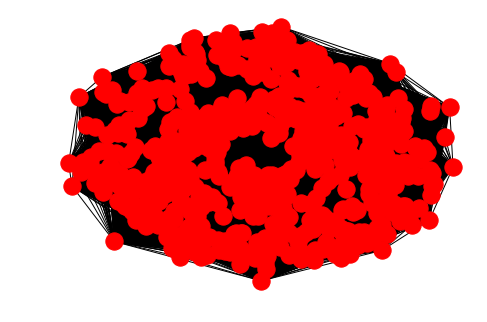